In [15]:
import pygame
import numpy as np
import numpy.linalg as la
import random as rdm
import math as mh
import math
import time
import matplotlib.pyplot as plt

FPS = 40
SForFrame = 1 / FPS
WIN_WIDTH = 1000
WIN_HEIGHT = 600
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
GRAY = (125, 125, 125)
LIGHT_BLUE = (64, 128, 255)
GREEN = (0, 128, 0)
RED = (255, 0, 0)
LIME = (0, 255, 0)
YELLOW = (225, 225, 0)
ORANGE = (255, 165, 0)
PINK = (230, 50, 230)
BGCOLOR = WHITE
ROBOTCOLOR = GRAY
WALLCOLOR = BLACK
LINECHARTCOLOR = GRAY

class VisualObj:
    def draw(self):
        pass

class ActiveObj(VisualObj):
    def action(self):
        pass
    
class GeomObj(ActiveObj):
    def getDist(self, oPos):
        pass
    def getXDiff(self, oPos):
        pass
    def getYDiff(self, oPos):
        pass
    def getYDist(self, oPos):
        return abs(self.getYDiff(oPos))
    def isAbove(self, oPos):
        return self.getYDiff(oPos) > 0
    
class Robot(GeomObj):
    def __init__(self, pos, V = np.array([0, 0]), Rvis = 10, r = 10, color = ROBOTCOLOR, Dir = np.array([1, 0])):
        self._dir = Dir
        self._live = True
        self._pos = pos
        self._V = V
        self._r = r
        self._color = color
    def rise(self):
        self._live = True
    def kill(self):
        self._live = False
    def isLive(self):
        return self._live
    def teleportation(self, tPos):
        self._pos = tPos
    def getPos(self):
        return self._pos
    def getDir(self):
        return self._dir
    def getOrtDir(self):
        return np.array([self._dir[1], -self._dir[0]])
    def setDir(self, nDir):
        self._dir = nDir / la.norm(nDir)
    def getDist(self, oPos):
        return la.norm(self._pos - oPos)
    def getXDiff(self, oPos):
        return self._pos[0] - oPos[0]
    def getYDiff(self, oPos):
        return self._pos[1] - oPos[1]
    def getDirDiff(self, oPos, Dir):
        u = self._pos - oPos
        return u[0] * Dir[0] + u[1] * Dir[1]
    def getRDirDiff(self, oPos):
        return self.getDirDiff(oPos, self.getDir())
    def getOrtRDirDiff(self, oPos):
        return self.getDirDiff(oPos, self.getOrtDir())
    def isDirAbove(self, oPos, oDir):
        return self.getDirDiff(oPos, oDir) < 0
    def inRank(self, oPos, buildWidth):
        return abs(self.getXDiff(oPos)) < buildWidth
    def setV(self, V):
        self._V = V
    def inN(self, RPos, RVis):
        return self.getDist(RPos) < RVis
    def isWall(self):
        return False
    
    def draw(self, sc, O):
        DispPos = self._pos + O;
        pygame.draw.circle(sc, self._color, (int(DispPos[0]), int(DispPos[1])), self._r)
    def hide(self, sc, O):
        DispPos = self._pos + O;
        pygame.draw.circle(sc, BGCOLOR, (int(DispPos[0]), int(DispPos[1])), self._r)
    def action(self):
        self._pos = self._pos + self._V;
    
class Wall(GeomObj):
    def __init__(self, A, B, width = 3, color = WALLCOLOR):
        self._A = A
        self._B = B
        self._color = color
        self._width = width
    def isLive(self):
        return True
    def getDist(self, oPos):
        v = self._A - self._B
        v = v / la.norm(v)
        oPos = oPos - self._A
        return abs(v[1] * oPos[0] - v[0] * oPos[1])
    def getYDiff(self, oPos):
        v = self._A - self._B
        return self._A[1] + (oPos[0] - self._A[0]) / v[0] * v[1] - oPos[1]
    def inN(self, RPos, RVis):
        return False
    def inRank(self, oPos, buildWidth):
        return True
    def isWall(self):
        return True
    def draw(self, sc, O):
        pygame.draw.line(sc, self._color, tuple(self._A + O), tuple(self._B + O), self._width)

class CurvedWall(Wall):
    def __init__(self, func, width = 12, color = WALLCOLOR, drawStep = 1):
        self._f = func
        self._width = width
        self._color = color
        self._drawStep = drawStep
    #norm(oDir) == 1
    def getNearestPoint(self, oPos, oDir, R = 1000, frec = 3):
        resDist = R
        res = oPos + RVis * oDir
        for ang in range(0, 180, frec):
            rAng = -ang / 180 * mh.pi
            c = mh.cos(rAng)
            s = mh.sin(rAng)
            cDir = np.array([oDir[0]*c-oDir[1]*s, oDir[0]*s+oDir[1]*c])
            eps = 1e-2
            r = self.getDirDiff(oPos, cDir, -R, R, eps)
            if abs(r) <= resDist - eps:
                resDist = abs(r)
                res = oPos + cDir * r
        return [resDist, res]
    def getTangentDir(self, X, h = 1e-2):
        tDir = np.array([2*h, self.getY(X+h) - self.getY(X-h)])
        return tDir / la.norm(tDir)
    def getDist(self, oPos):
        return abs(self.getYDiff(oPos)) #Вообще говоря, реальное расстояние до кривой нам не особо интересно
        #return min(la.norm(self.getNearestPoint(oPos, np.array([ 1, 0]), 100, 18)-oPos), 
        #           la.norm(self.getNearestPoint(oPos, np.array([-1, 0]), 100, 18)-oPos))
    def getDirDiff(self, oPos, oDir, l = -1000, r = 1000, eps = 1e-2):
        while r - l > eps:
            m = (l + r) / 2
            if oPos[1] + oDir[1] * m <= self._f(oPos[0] + oDir[0] * m):
                r = m
            else:
                l = m
        return r
    def isDirAbove(self, oPos, oDir, l = -1000, r = 1000, eps = 1e-2):
        return self.getDirDiff(oPos, oDir, l, r, eps) < 0
    def getYDiff(self, oPos):
        return self.getY(oPos[0]) - oPos[1]
    def getY(self, X):
        return self._f(X)
    def drawSeg(self, sc, O, L, R, drawStep):
        X = L
        Y = self._f(X)
        while X < R:
            nX = X + drawStep
            nY = self._f(nX)
            pygame.draw.line(sc, self._color, (X + O[0], Y + O[1]), (nX + O[0], nY + O[1]), self._width)
            X = nX
            Y = nY
    def draw(self, sc, O):
        self.drawSeg(sc, O, -O[0], WIN_WIDTH - O[0], self._drawStep)
        
class Obstacle(Wall):
    def __init__(self, upFunc, downFunc, L, R, width = 7, color = WALLCOLOR, drawStep = 1):
        if upFunc(L) != downFunc(L) or upFunc(R) != downFunc(R):
            print('Ошибка при создании объекта. Верхняя граница не согласована с нижней')
        self._uF = upFunc
        self._dF = downFunc
        self._L = L;
        self._R = R;
        self._width = width
        self._color = color
        self._drawStep = drawStep
    def getDist(self, oPos):
        if oPos[0] < self._L:
            return la.norm(oPos - np.array([self._L, self._uF(self._L)]))
        elif oPos[0] > self._R:
            return la.norm(oPos - np.array([self._R, self._uF(self._R)]))
        else:
            return abs(self.getYDiff(oPos))
    def getXDiff(self, oPos):
        if self._L < oPos[0]:
            return self._L - oPos[0]
        elif self._R > oPos[0]:
            return self._R - oPos[0]
        else:
            return 0
    def getYDiff(self, oPos):
        return self.getY(oPos) - oPos[1]
    def getY(self, oPos):
        if oPos[0] < self._L:
            return self._uF(self._L)
        elif oPos[0] > self._R:
            return self._uF(self._R)
        uY = self._uF(oPos[0])
        dY = self._dF(oPos[0])
        return uY if abs(oPos[1] - uY) < abs(oPos[1] - dY) else dY
    def drawSeg(self, sc, O, L, R, drawStep):
        L = max(L, self._L)
        R = min(R, self._R)
        X = L
        uY = self._uF(X)
        dY = self._dF(X)
        while X < R:
            nX = X + drawStep
            nuY = self._uF(nX)
            ndY = self._dF(nX)
            pygame.draw.line(sc, self._color, (X + O[0], uY + O[1]), (nX + O[0], nuY + O[1]), self._width)
            pygame.draw.line(sc, self._color, (X + O[0], dY + O[1]), (nX + O[0], ndY + O[1]), self._width)
            X = nX
            uY = nuY
            dY = ndY
    def draw(self, sc, O):
        self.drawSeg(sc, O, self._L, self._R, self._drawStep)
    
class Scene(ActiveObj):
    def __init__(self, sc, objs, GlobalCenter = np.array([0, 0])):
        self._sc = sc
        self._objects = objs
        self._O = GlobalCenter
    def draw(self):
        for obj in self._objects:
            if obj.isLive():
                obj.draw(self._sc, self._O)
    def action(self):
        for obj in self._objects:
            if obj.isLive():
                obj.action()  
                
class LineChart:
    def __init__(self, sc, GlobalCenter = np.array([0, 0]), FirstPnt = np.array([0, 0]), color = LINECHARTCOLOR, width = 3, Scale = np.array([1, 1])):
        self._sc = sc
        self._O = GlobalCenter
        self._prevPnt = FirstPnt
        self._color = color
        self._width = width
        self._S = Scale
    def addPnt(self, nextPnt):
        pygame.draw.line(sc, self._color, tuple(self._S*self._prevPnt+self._O), tuple(self._S*nextPnt+self._O), self._width)
        self._prevPnt = nextPnt
            
def gamma(arg, param):
    return param * arg / (1 + arg * arg) ** 0.5

def theta(arg, param):
    return param * arg

def calcL(objs, agent, RVis, buildWidth):
    rDist = RVis
    res = None
    for obj in objs:
        cDist = abs(obj.getDirDiff(agent.getPos(), agent.getOrtDir(), -RVis, RVis)) if obj.isWall() else obj.getDist(agent.getPos())
        if obj.isLive() and cDist < RVis and obj.inRank(agent.getPos(), buildWidth):
            YDist = cDist if obj.isWall() else abs(agent.getOrtRDirDiff(obj.getPos()))
            if rDist > YDist:
                rDist = YDist
                res = obj
        #Многополосный режим
        #if obj.isLive() and obj.getDist(RPos) < RVis and obj.inRank(RPos, buildWidth):
#Old
#             YDist = obj.getYDist(RPos)
#             if rDist > YDist:
#                 rDist = YDist
#                 res = obj
    return [rDist, res]

def calcN(objs, RID):
    res = []
    for Id, obj in enumerate(objs):
        if obj.isLive() and Id != RID and obj.inN(objs[RID].getPos(), RVis):
            res.append(Id)
    return res

def forwardWallDist(objs, RPos, RVis, buildWidth, wall):
    res = 0
    for obj in objs:
        if obj.isLive() and not obj.isWall() and obj.getDist(RPos) < RVis:
            XDiff = obj.getXDiff(RPos)
            if 0.5 * buildWidth < XDiff and XDiff < 2.5 * buildWidth:
                if res == 0:
                    res = wall.getDist(obj.getPos())
                else:
                    res = min(res, wall.getDist(obj.getPos()))
    return res

def splitAboveBelow(objs, RID, rDir = np.array([0, -1])):
    resAbove = []
    resBelow = []
    for Id, obj in enumerate(objs):
        if obj.isLive() and Id != RID:
            if obj.isDirAbove(objs[RID].getPos(), rDir):
                resAbove.append(obj)
            else:
                resBelow.append(obj)
    return [resAbove, resBelow]

def getAbove(objs, RID):
    res = []
    for Id, obj in enumerate(objs):
        if obj.isLive() and Id != RID and obj.isAbove(objs[RID].getPos()):
            res.append(obj)
    return res

def getBelow(objs, RID):
    res = []
    for Id, obj in enumerate(objs):
        if obj.isLive() and Id != RID and not obj.isAbove(objs[RID].getPos()):
            res.append(obj)
    return res

def calcV(objs, N, LPlus, LMinus, V_, p1, p2, RID, buildWidth):
    Vx = 0
    for j in N:
        #Обычный режим
        #Vx = Vx + gamma(objs[j].getDirDiff(objs[RID].getPos(), objs[RID].getDir()), p1);
        #Многополосный режим
        if objs[j].inRank(objs[RID].getPos(), buildWidth):
            Vx = Vx + gamma(objs[j].getXDiff(objs[RID].getPos()), p1)
        elif abs(objs[j].getXDiff(objs[RID].getPos())) < 3 * buildWidth:
            if objs[j].getPos()[0] < objs[RID].getPos()[0]:
                Vx = Vx + gamma(objs[j].getXDiff(objs[RID].getPos() - np.array([2 * buildWidth, 0])), p1)
            else:
                Vx = Vx + gamma(objs[j].getXDiff(objs[RID].getPos() + np.array([2 * buildWidth, 0])), p1)
    if len(N) > 0:
        Vx = Vx / len(N) + V_
    else:
        Vx = V_
    Vy = theta(LPlus, p2) - theta(LMinus, p2)
    return np.array([Vx, Vy])

#Вернёт координаты случайно точки круга радиуса R с центров в (OX, OY) (равномерное распределение)
def getRndCrcPnt(R, OX = 0, OY = 0):
    X = rdm.uniform(-R, R)
    Y = rdm.uniform(-R, R)
    #Генерируем случайную точку внутри квадрата пока не попадём в круг
    while X ** 2 + Y ** 2 > R ** 2:
        X = rdm.uniform(-R, R)
        Y = rdm.uniform(-R, R)
        
    return np.array([X + OX, Y + OY])
      
#задаются константы
W = 300 #corridor width
rCnt = 16 #robots count
minRCnt = 36 #minimum robots count
killRisePeriod = 500 
maxKillGroupSize = 15 #maximum of destroyed group
RVis = 100 #vision radius
RDis = 100500
maxV = 8 #maximum speed
V_ = 2 #desired speed
CC = 0.1
Mult = 4
bias = 0
O = np.array([0, 300])
checkCondition = False;
condition = True;

buildWidth = RVis / 5;
MaxLMinusDist = (RVis ** 2 - 4 * buildWidth ** 2) ** 0.5 - 10
MaxWallDist = 7 * MaxLMinusDist / 12;
MinWallDist = 3 * MaxLMinusDist / 12;

#проверка на допустимость констант
if W / minRCnt > RVis:
    print('Плохое соотношение W, minRCnt, RVis')
if W / rCnt > RVis:
    print('Плохое соотношение W, rCnt, RVis')
    condition = False;
if condition or not checkCondition:
    #control algorithm coefficients calculation
    BB = CC * theta(RVis, 1)
    p1 = (((1 + BB ** 2) * maxV ** 2 - (BB * V_) ** 2) ** 0.5 - V_) / (1 + BB ** 2)
    p2 = Mult * CC * p1
    liveCnt = rCnt
    
    if condition:
        D = max((RVis ** 2 - (W / rCnt) ** 2) ** 0.5, 50)
    else:
        D = 100;
    #случайно раскидываются роботы в полосе и инициализируются стенки
    #objs = [Robot(np.array([rdm.uniform(0, D), rdm.uniform(-W/2+50-bias, W/2-50-bias)])) for j in range(0, rCnt)]
    
    #случайно раскидываются роботы в окрестности центра коридора
    #objs = [Robot(getRndCrcPnt(D / 2, D / 2, -bias)) for j in range(0, rCnt)]
    
    #инициализируем роботов с нулевыми координатами
    objs = [Robot(np.array([0, 0])) for j in range(0, rCnt)]
    
    #Прямые стенки
    #objs.append(Wall(A = np.array([-10, -W / 2 - bias]), B = np.array([WIN_WIDTH + 10, -W / 2 + bias])))
    #objs.append(Wall(A = np.array([-10, W / 2 - bias]), B = np.array([WIN_WIDTH + 10, W / 2 + bias])))
    
    #Кривые параллельные стенки
        #Самое простое
    #objs.append(CurvedWall(lambda x: 40 * math.sin(x/50 + 3) - W/2))
    #objs.append(CurvedWall(lambda x: 40 * math.sin(x/50 + 3) + W/2))
    
        #Комбинация синусов (Переиодичная)
    #objs.append(CurvedWall(lambda x: 10 * (math.sin(x/7) + math.sin(x/13)) - W/2))
    #objs.append(CurvedWall(lambda x: 10 * (math.sin(x/7) + math.sin(x/13)) + W/2))
    
        #Комбинация синусов (Непериодичная)
    #objs.append(CurvedWall(lambda x: 10*mh.sin(7**0.5*x/39) + 11*mh.sin(3**0.5*x/37) + 7*mh.sin(2**0.5*x/29) - W/2))
    #objs.append(CurvedWall(lambda x: 10*mh.sin(7**0.5*x/39) + 11*mh.sin(3**0.5*x/37) + 7*mh.sin(2**0.5*x/29) + W/2))
    
        #Плохой тест
    #objs.append(CurvedWall(lambda x: 20 * (math.sin(x/5) + math.sin(x/7)) - W/2))
    #objs.append(CurvedWall(lambda x: 20 * (math.sin(x/5) + math.sin(x/7)) + W/2))
    
        #Кривые и смещенные
    #objs.append(CurvedWall(lambda x: 10 * math.sin(x/11) + x * 0.2 - W))
    #objs.append(CurvedWall(lambda x: 10 * math.sin(x/11) + x * 0.2))
    
        #
    #objs.append(CurvedWall(lambda x: 7 * (mh.sin(x/13) + mh.sin(x/17)) - x * 0.2))
    #objs.append(CurvedWall(lambda x: 7 * (mh.sin(x/13) + mh.sin(x/17)) - x * 0.2 + W))
    
    #Кривые сужающиеся расширяющиеся стенки
        #Самое простое
    #objs.append(CurvedWall(lambda x:  40 * math.sin(2 * math.pi * x/200) - W/2))
    #objs.append(CurvedWall(lambda x: -40 * math.sin(2 * math.pi * x/200) + W/2))
    
        #
    #objs.append(CurvedWall(lambda x:  10 * (math.sin(x/5) + math.sin(x/7)) - W/2))
    #objs.append(CurvedWall(lambda x: -10 * (math.sin(x/5) + math.sin(x/7)) + W/2))
    
        #Плохой тест
    #objs.append(CurvedWall(lambda x:  20 * (math.sin(x/5) + math.sin(x/7)) - W/2))
    #objs.append(CurvedWall(lambda x: -20 * (math.sin(x/5) + math.sin(x/7)) + W/2))
    
        #Кривые и смещённые
    #Нисходящий
    #objs.append(CurvedWall(lambda x:  10 * math.sin(x/11) + x * 0.25 - W))
    #objs.append(CurvedWall(lambda x: -10 * math.sin(x/11) + x * 0.25 ))
    
    #Восходящий
    #objs.append(CurvedWall(lambda x:  10 * math.sin(x/11) - x * 0.25 ))
    #objs.append(CurvedWall(lambda x: -10 * math.sin(x/11) - x * 0.25 + W))
    
        #
    #objs.append(CurvedWall(lambda x:  10 * (math.sin(x/17) + math.sin(x/23)) + x * 0.25 - W))
    #objs.append(CurvedWall(lambda x: -10 * (math.sin(x/17) + math.sin(x/23)) + x * 0.25))
    
    #objs.append(CurvedWall(lambda x: 10 * (math.sin(x/7) + math.sin(x/13)) - W/2))
    #objs.append(CurvedWall(lambda x: 10 * (math.sin(x/7) + math.sin(x/13)) + W/2))
    
    #Streight tapering walls
    w = 100
    #objs.append(CurvedWall(lambda x: -w/2 - x * 0.25))
    #objs.append(CurvedWall(lambda x:  w/2 + x * 0.25))
    
    #Streight walls
    #objs.append(CurvedWall(lambda x: -W/2))
    #objs.append(CurvedWall(lambda x: +W/2))
    
    #Steight offset walls
    #objs.append(CurvedWall(lambda x: -x * 0.4))
    #objs.append(CurvedWall(lambda x: -x * 0.4 + W))
    
    #Sinus walls
    #objs.append(CurvedWall(lambda x: 40 * math.sin(x/50) - W/2))
    #objs.append(CurvedWall(lambda x: 40 * math.sin(x/50) + W/2))
    
    #Sinus sum offset walls
    #objs.append(CurvedWall(lambda x:  10 * (math.sin(x/17) + math.sin(x/23)) + x * 0.35 - W))
    #objs.append(CurvedWall(lambda x: -10 * (math.sin(x/17) + math.sin(x/23)) + x * 0.35))
    
    #_____      _____
    #     \____|
    #      ____  
    #_____|    \_____
    OX = WIN_WIDTH/2
    aa = 145
    bb = 200
    cc = 1.5
    w = 215
    objs.append(CurvedWall(lambda x: -cc*(abs(x-aa-OX)+abs(x+aa-OX)-abs(x-bb-OX)-abs(x+bb-OX))-w))
    objs.append(CurvedWall(lambda x:  cc*(abs(x-aa-OX)+abs(x+aa-OX)-abs(x-bb-OX)-abs(x+bb-OX))+w))
    
    #Angle walls
    P = 170
    a = WIN_WIDTH/2
    #objs.append(CurvedWall(lambda x: P * (1 - abs(x-a) / a) - W))
    #objs.append(CurvedWall(lambda x: P * (1 - abs(x-a) / a)))
    
    #Arc walls
    R = 900
    a = WIN_WIDTH/2
    y0 = mh.sqrt(R ** 2 - a ** 2)
    #objs.append(CurvedWall(lambda x: y0 + WIN_HEIGHT/2 - W - mh.sqrt(R ** 2 - (x - a) ** 2)))
    #objs.append(CurvedWall(lambda x: y0 + WIN_HEIGHT/2 - mh.sqrt(R ** 2 - (x - a) ** 2)))
    
    #Arc plus sinus walls
    AA = WIN_WIDTH/2 + 50
    BB = WIN_HEIGHT/1.8
    #objs.append(CurvedWall(lambda x: -BB/AA*mh.sqrt(AA**2-((x-WIN_WIDTH/2)/K)**2) + 11*mh.sin(2**0.5*x/31) + 15*mh.sin(x/13) + W/4))
    #objs.append(CurvedWall(lambda x: -BB/AA*mh.sqrt(AA**2-((x-WIN_WIDTH/2)/K)**2) + 11*mh.sin(2**0.5*x/31) + 15*mh.sin(x/13) + 5*W/4))
    
    #objs.append(CurvedWall(lambda x: -BB/AA*mh.sqrt(AA**2-((x-WIN_WIDTH/2))**2) + 11*mh.sin(2**0.5*x/31) + 15*mh.sin(x/13) + W/4))
    #objs.append(CurvedWall(lambda x: -BB/AA*mh.sqrt(AA**2-((x-WIN_WIDTH/2))**2) - 11*mh.sin(2**0.5*x/31) - 15*mh.sin(x/13) + 5*W/4))
    
    #Chaotic walls
    a = WIN_WIDTH/2
    #objs.append(CurvedWall(lambda x: 60 * mh.asin(mh.sin((x + 170)/200)) + 33 * mh.sin(x/201) * mh.sin(x/17) - W/2))
    #objs.append(CurvedWall(lambda x: 30 * mh.asin(mh.sin(x/100)) + 23 * mh.sin(x/201) * mh.sin(x/17) + 11 * mh.asin(mh.sin(x/20)) + W/2))
    
    #Zigzag walls
    #objs.append(CurvedWall(lambda x: 40 * mh.asin(mh.sin((x + 170)/40)) - W/2))
    #objs.append(CurvedWall(lambda x: 40 * mh.asin(mh.sin((x + 170)/40)) + W/2))
    
    TT = np.arange(0, 10, 0.025)
    XX = [[] for j in range(0, rCnt)]
    LPM = [[] for j in range(0, rCnt)]
    
    #Simulation initialization
    pygame.init()

    clock = pygame.time.Clock()

    sc = pygame.display.set_mode((WIN_WIDTH, WIN_HEIGHT))

    sm = Scene(sc, objs, O)

    sc.fill(BGCOLOR)
    
    #Robots placement at the beggining of the corridor
    AverageX = 0
    for j in range(0, rCnt):
        objs[j].teleportation(getRndCrcPnt(min(D/2, RDis, W/2), D/2, (objs[rCnt].getY(D/2) + objs[rCnt+1].getY(D/2))/2))
        AverageX = AverageX + objs[j].getPos()[0]
    AverageX = AverageX / rCnt
    XPosCharts = [LineChart(sc, np.array([50, WIN_HEIGHT-150]), np.array([0, AverageX-objs[j].getPos()[0]]), width = 2, Scale = np.array([1, 3])) for j in range(0, rCnt)]
    for j in range(0, rCnt):
        XX[j].append(AverageX - objs[j].getPos()[0])
        
    #Robots direction calculation initialization
    forg = 0.995 #Forgetting coeffitient
    sCoef = 0.3
    V_t = [np.array([sCoef/(1-forg), 0]) for j in range(0, rCnt)]
    
    #Wall drawing
    objs[rCnt].draw(sc, O)
    objs[rCnt + 1].draw(sc, O)
    
    #Obstacles initialization
#     R = 600
#     xC = 500 
#     xR = 200
#     yC = mh.sqrt(R ** 2 - xR ** 2)
#     fColl = lambda x: (10*mh.sin(7**0.5*x/39) + 11*mh.sin(3**0.5*x/37) + 7*mh.sin(2**0.5*x/29))/3;
#     objs.append(Obstacle(lambda x: -yC+mh.sqrt(R**2-(x-xC)**2) + fColl(x), lambda x: yC-mh.sqrt(R**2-(x-xC)**2) + fColl(x), xC-xR, xC+xR))
    
    #Obstacles drawing
#     objs[rCnt + 2].draw(sc, O)
    
    #симуляция
    #time.sleep(5)
    running = 1;
    while running >= 0:
        #sc.fill(BGCOLOR)
        StartTime = time.time()

        for i in pygame.event.get():
            if i.type == pygame.QUIT: running = -100500;

        #sm.draw()
        #рисуются живые роботы и границы коридора при необходимости
        drawDist = 20
        for j in range(0, rCnt):
            if objs[j].isLive():
                #Рисуется ближайшая к роботу точка препятствия
#                 nPnt = objs[rCnt].getNearestPoint(objs[j].getPos(), np.array([1, 0]), RVis, 5)
#                 nPnt[1] = nPnt[1] + O
#                 pygame.draw.circle(sc, RED, (int(nPnt[1][0]), int(nPnt[1][1])), 7)
                objs[j].draw(sc, O)
                RPos = objs[j].getPos()
                if abs(objs[rCnt].getYDiff(RPos)) < drawDist:
                    objs[rCnt].drawSeg(sc, O, RPos[0] - drawDist, RPos[0] + drawDist, 1)
                if abs(objs[rCnt + 1].getYDiff(RPos)) < drawDist:
                    objs[rCnt + 1].drawSeg(sc, O, RPos[0] - drawDist, RPos[0] + drawDist, 1)
                #прорисовка препятствий
#                 if abs(objs[rCnt + 2].getDist(RPos)) < drawDist:
#                     objs[rCnt + 2].drawSeg(sc, O, RPos[0] - drawDist, RPos[0] + drawDist, 1)

        pygame.display.update()
        
        #Все перемещения происходят здесь
        numDisappear = 0
        AverageX = 0
        for j in range(0, rCnt):
            if objs[j].isLive():
                N = calcN(objs, j) #Visible robots set
                #Direction calculation and sincronization
#                 pntInfo1 = objs[rCnt].getNearestPoint(objs[j].getPos(), objs[j].getDir(), RVis, 20)
#                 pntInfo2 = objs[rCnt + 1].getNearestPoint(objs[j].getPos(), objs[j].getDir(), RVis, 20)
#                 #pntDist1 = objs[rCnt].getDirDiff(objs[j].getPos(), objs[j].getDir(), -RVis-10, RVis+10)
#                 #pntDist2 = objs[rCnt + 1].getDirDiff(objs[j].getPos(), objs[j].getDir(), -RVis-10, RVis+10)
#                 dirSum = np.array([0, 0])
#                 for k in N:
#                     dirSum = dirSum + objs[k].getDir()
#                 lN = len(N);
#                 if pntInfo1[0] < RVis:
#                     V_t[j] = forg * V_t[j] + objs[rCnt].getTangentDir(pntInfo1[1][0])
#                     nDir = (dirSum + V_t[j] / la.norm(V_t[j])) / (1 + lN)
#                     objs[j].setDir(nDir)
#                 elif pntInfo2[0] < RVis:
#                     V_t[j] = forg * V_t[j] + objs[rCnt + 1].getTangentDir(pntInfo2[1][0])
#                     nDir = (dirSum + V_t[j] / la.norm(V_t[j])) / (1 + lN)
#                     objs[j].setDir(nDir)                    
#                 elif lN > 0:
#                     nDir = dirSum / lN
#                     objs[j].setDir(nDir / la.norm(nDir))
                splt = splitAboveBelow(objs, j, objs[j].getOrtDir())
                LMinusInf = calcL(splt[1], objs[j], RVis, buildWidth)
                LPlusInf = calcL(splt[0], objs[j], MaxLMinusDist, buildWidth)
                LMinus = LMinusInf[0]
                LPlus = LPlusInf[0]
                #Если слева ничего нет то идём влево, иначе всё по старому
                #if LMinus >= MaxLMinusDist:
                #    newV = [V_, -0.5 * (maxV ** 2 - V_ ** 2) ** 0.5]
                #else:
                
                #Для вывода графика
                #if len(LPM[j]) < len(TT):
                #    LPM[j].append(LPlus - LMinus)
                
                newV = calcV(objs, N, LPlus, LMinus, V_, p1, p2, j, buildWidth)
                
                #Acceleration for multiline mode
                if LMinusInf[1] != None and LMinusInf[1].isWall() and forwardWallDist(objs, objs[j].getPos(), RVis, buildWidth, LMinusInf[1]) > MaxWallDist:
                    newV[0] = newV[0] * 2
                    
                #Замедление при подходе к стенке
                #При наличии препятствий
                #wallDist = min(wallDist, objs[rCnt + 2].getDist(objs[j].getPos()))
                pntInfo1 = objs[rCnt].getNearestPoint(objs[j].getPos(), objs[j].getDir(), RVis, 10)
                pntInfo2 = objs[rCnt + 1].getNearestPoint(objs[j].getPos(), objs[j].getDir(), RVis, 10)
                if pntInfo1[0] < MinWallDist:
                    #newV[0] = newV[0] * min(max(0.15, wallDist / MinWallDist), 0.5)
                    nDir = pntInfo1[1] - objs[j].getPos()
                    nDir = nDir / la.norm(nDir)
                    proec = newV[0] * nDir[0] + newV[1] * nDir[1]
                    newV = newV - max(proec, 0) * nDir
                elif pntInfo2[0] < MinWallDist:
                    nDir = pntInfo2[1] - objs[j].getPos()
                    nDir = nDir / la.norm(nDir)
                    proec = newV[0] * nDir[0] + newV[1] * nDir[1]
                    newV = newV - max(proec, 0) * nDir
                    
                absV = la.norm(newV)
                if absV > maxV:
                    newV = newV / absV * maxV
                d = objs[j].getDir()
                objs[j].setV(np.array([d[0]*newV[0]-d[1]*newV[1],d[1]*newV[0]+d[0]*newV[1]]))
                if (objs[j].getPos() + O)[0] > WIN_WIDTH + 15:
                    numDisappear = numDisappear + 1
                AverageX = AverageX + objs[j].getPos()[0]
        AverageX = AverageX / rCnt
        #for j in range(0, rCnt):
        #    XPosCharts[j].addPnt(np.array([running, AverageX-objs[j].getPos()[0]]))
        for j in range(0, rCnt):
            if len(XX[j]) < len(TT):
                XX[j].append(AverageX - objs[j].getPos()[0])
                 
        if running % killRisePeriod == 0:
            #Kills or rises robots
            doKill = (np.random.randint(2) == 1 or liveCnt == rCnt) and (liveCnt > minRCnt)
            if doKill:
                #Kills robots
                killGroupSize = np.random.randint(min(liveCnt - minRCnt + 1, maxKillGroupSize + 1))
                print('Killed: ' + str(killGroupSize))
                for j in range(0, killGroupSize):
                    Id = np.random.randint(rCnt)
                    while not objs[Id].isLive():
                        Id = np.random.randint(rCnt)
                    liveCnt = liveCnt - 1
                    objs[Id].kill()
            else:
                #Rises robots
                risePnt = np.array([0, 0])
                for j in range(0, rCnt):
                    if objs[j].isLive():
                        risePnt = risePnt + objs[j].getPos()
                risePnt = risePnt / liveCnt
                riseCnt = 0
                for j in range(0, rCnt):
                    if not objs[j].isLive():
                        doRise = np.random.randint(2) == 0 #вероятность воскресить 1/2
                        if doRise:
                            #Воскрешение в пределах полосы
                            #X = rdm.uniform(risePnt[0] - D/2, risePnt[0] + D/2)
                            #Y = rdm.uniform(risePnt[1] - W/2 + 50, risePnt[1] + W/2 - 50)
                            #objs[j].teleportation(np.array([X, Y]))
                            
                            #Воскрешение в окресности центра строя
                            objs[j].teleportation(getRndCrcPnt(D/2, risePnt[0], risePnt[1]))
                            objs[j].rise()
                            riseCnt = riseCnt + 1
                liveCnt = liveCnt + riseCnt
                print('Risen:  ' + str(riseCnt)) 
        
        #для цикличности "телепортируем" роботов в начало коридора после того как все они заедут за границу
        #наблюдаемой зоны
        #Просто обнуляем координаты по X (ну ещё и смещение учитывается, но не особо что-то даёт в общем случае)
        #if numDisappear >= liveCnt:
        #    for j in range(0, rCnt):
        #        if objs[j].isLive():
        #           objs[j].teleportation(objs[j].getPos() - np.array([WIN_WIDTH, 2 * bias]))
        
        #Смотрим на расстояние до стеночки каждого робота и телепортируем так, чтобы оно сохранялось
        if numDisappear >= liveCnt:
            for j in range(0, rCnt):
                if objs[j].isLive():
                    tpX = objs[j].getPos()[0] - WIN_WIDTH
                    tpY = objs[rCnt].getY(tpX) - objs[rCnt].getYDiff(objs[j].getPos())
                    objs[j].teleportation(np.array([tpX, tpY]))
                    
        #стираем роботов
        for j in range(0, rCnt):
            objs[j].hide(sc, O)
        
        sm.action()
        
        running = running + 1
        SleepTime = SForFrame + StartTime - time.time()
        if SleepTime > 0:
            time.sleep(SleepTime)
        #clock.tick(FPS)
    pygame.quit()
    
    #инициализация графиков
    #fig1 = plt.figure()
    #fig2 = plt.figure()

    #ConvX = fig1.add_subplot(111)
    #ConvY = fig2.add_subplot(111)
    #Вывод графиков
    #Координата по X, относительно среднего арифметического абсолютных координат X роботов
    #if len(TT) == len(XX[0]):
    #    for j in range(0, rCnt):
    #        ConvX.plot(TT, np.array(XX[j]), 'k')
    
    #Разница расстояний между левым и правым ближайшими объектами
    #if len(TT) == len(LPM[0]):
    #    for j in range(0, rCnt):
    #        ConvY.plot(TT, np.array(LPM[j]), 'k')
    
    #plt.show()

Risen:  0


In [10]:
class Worker:
    def __init__(self, DoFunc):
        self._DoFunc = DoFunc
    def Do(self, arg):
        self._DoFunc(arg)
        
def DoF(arg):
    print(arg)
    
def DoF2(arg):
    print('Kek')
    
worker = Worker(DoF)
worker.Do('Hello!!!')
worker2 = Worker(DoF2)
worker2.Do('Buba')

Hello!!!
Kek


Major X-ticks locations: [-20.   0.  20.  40.  60.  80. 100. 120.]
Major X-ticks labels: <a list of 8 Text major ticklabel objects>
Major X-ticks tick lines: <a list of 16 Line2D ticklines objects>


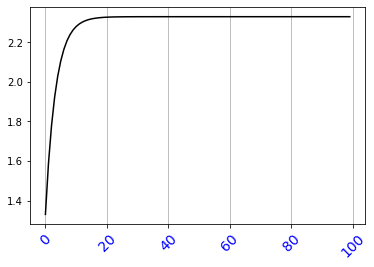

In [11]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()

ax = fig.add_subplot(111)

x = np.arange(100)
y = -np.exp(-0.3*x) + 2.33

ax.plot(x, y, 'k')

xax = ax.xaxis   # или xax = ax.get_xaxis()

xlocs = xax.get_ticklocs()
print ('Major X-ticks locations:', xlocs)
xlabels = xax.get_ticklabels()
print ('Major X-ticks labels:', xlabels)
xlines = xax.get_ticklines()
print ('Major X-ticks tick lines:', xlines)

# Линии вспомогательной сетки (главные деления) только по оси абсцисс
xax.grid(True)

for label in xlabels:
    # цвет подписи деленений оси OX
    label.set_color('blue')
    # поворот подписей деленений оси OX 
    label.set_rotation(45)
    # размер шрифта подписей делений оси OX 
    label.set_fontsize(14)

#save('pic_8_1_1', fmt='png')
#save('pic_8_1_1', fmt='pdf')
    
plt.show()

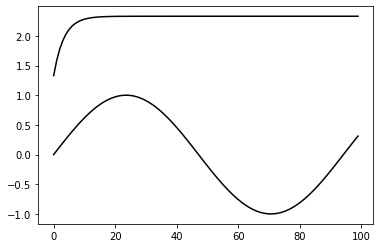

In [83]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()

ax = fig.add_subplot(111)

x = np.arange(100)
y = -np.exp(-0.3*x) + 2.33

y1 = np.sin(x/15)

ax.plot(x, y, 'k')
ax.plot(x, y1, 'k')

xax = ax.xaxis   # или xax = ax.get_xaxis()

plt.show()

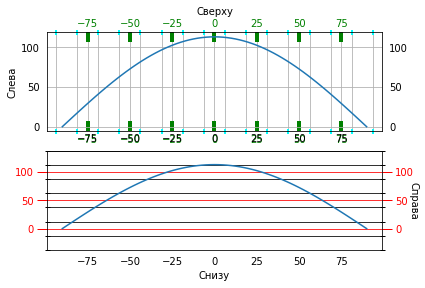

In [74]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(-90, 92.5 , 2.5)
y = 113.3*np.cos(x*np.pi/180.)
z = 113.3*np.sin(x*np.pi/180.)

fig = plt.figure()

ax = fig.add_subplot(211)
ax.plot(x, y)

ax.tick_params(axis='x', which='major', 
               labelleft='off', labelright='off', labeltop='on', labelbottom='on', 
               bottom=True, top=True,
               direction='in', length=10, width=4, colors='g')

old_major = ax.get_xticks()
N = 0.25
lag = (old_major[1] - old_major[0])*N
new_minor = np.arange(old_major[0] + lag, old_major[-1], 2*lag)
ax.set_xticks(new_minor, minor = True)

ax.tick_params(axis='x', which='minor', 
               labeltop='on', labelbottom='on', 
               bottom=True, top=True,
               direction='inout', length=5, width=2, colors='cyan')

ax.tick_params(axis='y', 
               labelleft='off', labelright='off',
               left=False, right=False)

ax.grid(True, which='major')
ax.grid(True, which='minor')

ax.yaxis.set_label_position('left')
ax.set_ylabel(u'Слева')
ax.xaxis.set_label_position('top')
ax.set_xlabel(u'Сверху')

# ************************************************
ax = fig.add_subplot(212)

ax.plot(x, y)
ax.tick_params(axis='both', reset=True)

ax.tick_params(axis='y', which='major', 
               labelleft='on', labelright='on', 
               left=True, right=True,
               direction='out', length=10, width=1., colors='r')

old_major = ax.get_yticks()
N = 0.25
lag = (old_major[1] - old_major[0])*N
new_minor = np.arange(old_major[0] + lag, old_major[-1], 2*lag)
ax.set_yticks(new_minor, minor = True)

ax.tick_params(axis='y', which='minor', 
               labelleft='on', labelright='on', 
               left=True, right=True,
               direction='inout', length=5, width=1., colors='k')

ax.tick_params(axis='x',
               labeltop='off', labelbottom='off', 
               bottom=False, top=False)

ax.yaxis.set_label_position('right')
ax.set_ylabel(u'Справа', rotation=270)

ax.xaxis.set_label_position('bottom')
ax.set_xlabel(u'Снизу')

ax.grid(True, axis='y', which='major', color='red')
ax.grid(True, axis='y', which='minor', color='k')

#save('pic_8_3_3', fmt='png')
#save('pic_8_3_3', fmt='pdf')

plt.show()

In [108]:
arr = [j for j in range(0, 5)]
arr
arr[:3]
arr[1:3]

[1, 2]

In [223]:
np.matrix([[1, 2], [3, 4]]) * np.array([2, 3])

ValueError: shapes (2,2) and (1,2) not aligned: 2 (dim 1) != 1 (dim 0)